# TP1 - Menceyra - Viaggio

### Pipeline: 
(1) Deteccion y descripcion de Caracteristicas visuales(features)

(2) Supresion no Maxima Adaptativa

(3) Asociacion de caracteristicas(Matching)

(4) Asociacion de correspondencias

(5) Eliminacion de outliers utilizando RANSAC

(6) Estimacion de la homografia

(7) Juntar y mezclar imagenes

### (1) Etapa 1 - Deteccion de Caracteristicas - 

[udesa_0.jpg] keypoints=3118 | desc_shape=(3118, 128)
[udesa_1.jpg] keypoints=3038 | desc_shape=(3038, 128)  <- ANCLA
[udesa_2.jpg] keypoints=2756 | desc_shape=(2756, 128)


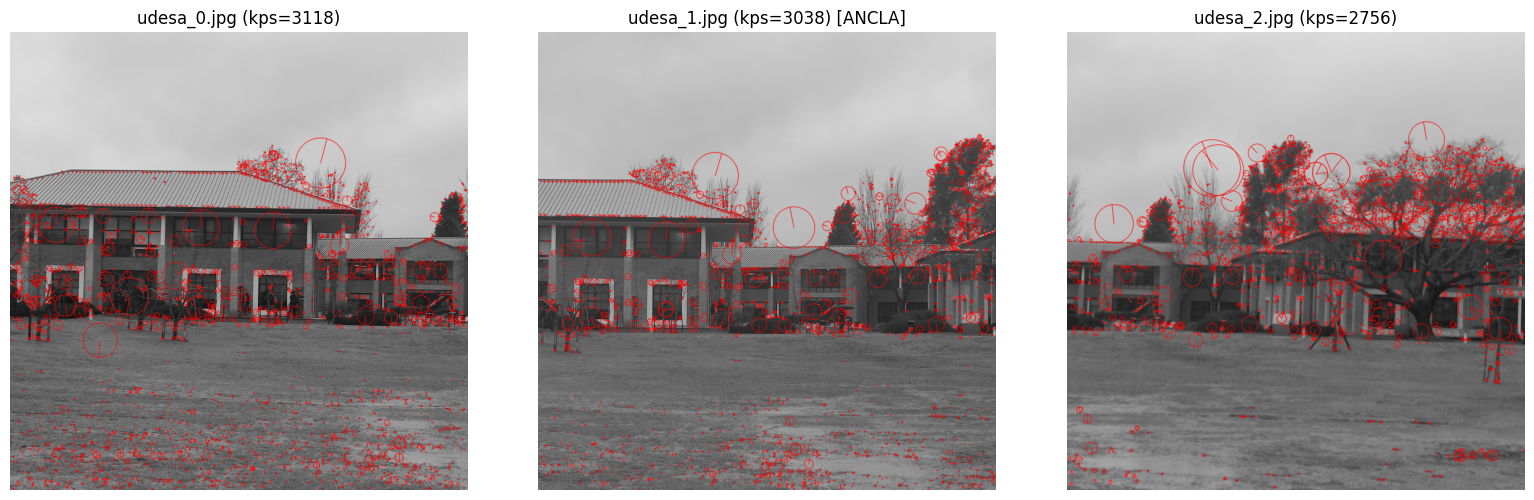

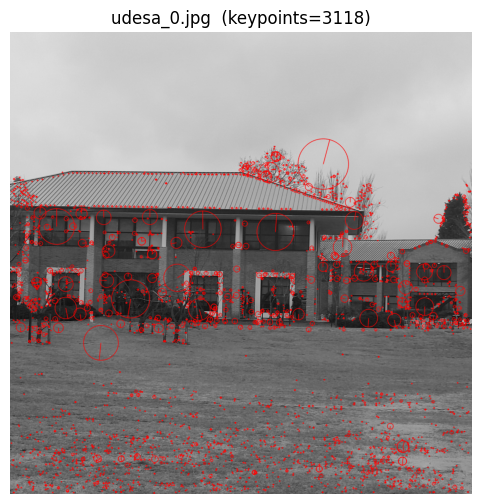

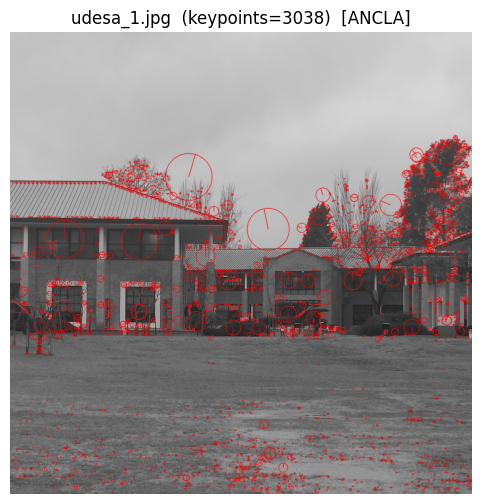

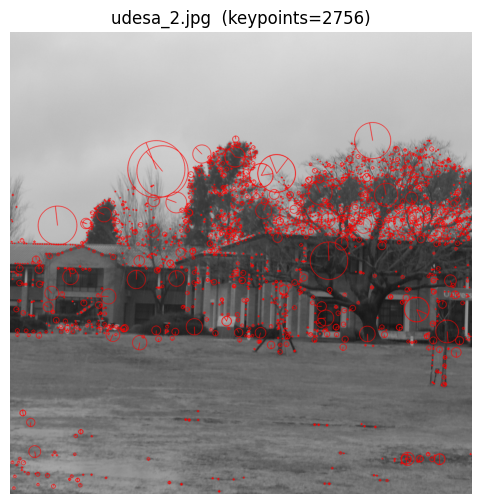

In [5]:
# === Etapa 1: Detección y descripción de características (SIFT) ===
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- Config simple ---
IMG_DIR = Path("img")                 # carpeta 
SET = "udesa"                         # prefijo de las imágenes a usar
FILES = [f"{SET}_0.jpg", f"{SET}_1.jpg", f"{SET}_2.jpg"]
ANCHOR_IDX = 1                        # tomo la del medio como "ancla"
RESIZE_W = 1000                       # ancho target (None = tamaño original)

def imread_rgb(path: Path):
    """Leo con cv2 y devuelvo en RGB (para mostrar con plt)."""
    bgr = cv2.imread(str(path), cv2.IMREAD_COLOR)
    assert bgr is not None, f"No pude leer {path}"
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

def resize_w(img, w):
    """Redimensiono manteniendo aspecto (suave para trabajar cómodo)."""
    if w is None or img.shape[1] <= w:
        return img
    r = w / img.shape[1]
    return cv2.resize(img, (int(img.shape[1]*r), int(img.shape[0]*r)), interpolation=cv2.INTER_AREA)

# --- Cargo + preparo (RGB para mostrar luego, GRAY para SIFT) ---
imgs_rgb, imgs_gray = [], []
for f in FILES:
    rgb = imread_rgb(IMG_DIR / f)
    rgb = resize_w(rgb, RESIZE_W)
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    imgs_rgb.append(rgb)
    imgs_gray.append(gray)

# --- SIFT (si falla, instalar opencv-contrib-python) ---
sift = cv2.SIFT_create()

kps_list, desc_list = [], []
for gray in imgs_gray:
    kps, desc = sift.detectAndCompute(gray, None)
    kps_list.append(kps)
    desc_list.append(desc)

# --- Info rápida para entender qué tenemos ---
for i, f in enumerate(FILES):
    shp = None if desc_list[i] is None else desc_list[i].shape
    print(f"[{f}] keypoints={len(kps_list[i])} | desc_shape={shp}" + ("  <- ANCLA" if i==ANCHOR_IDX else ""))

# === Visualización de keypoints ===
# Usamos la imagen en escala de grises como base para que los puntos se vean claros

# --- Lado a lado (overview rápido) ---
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for i, ax in enumerate(axes):
    vis = cv2.drawKeypoints(
        imgs_gray[i], kps_list[i], None,
        color=(255,0,0),
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    ax.imshow(vis, cmap="gray")
    ax.set_title(f"{FILES[i]} (kps={len(kps_list[i])})" + (" [ANCLA]" if i==ANCHOR_IDX else ""))
    ax.axis("off")
plt.tight_layout()
plt.show()

# --- Cada una individual (zoom para ver detalles) ---
for i in range(3):
    vis = cv2.drawKeypoints(
        imgs_gray[i], kps_list[i], None,
        color=(255,0,0),
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    plt.figure(figsize=(8,6))
    plt.imshow(vis, cmap="gray")
    plt.title(f"{FILES[i]}  (keypoints={len(kps_list[i])})" + ("  [ANCLA]" if i==ANCHOR_IDX else ""))
    plt.axis("off")
    plt.show()

# --- Dejamos todo listo para el Paso 2 (ANMS) y los siguientes ---
pano_data = {
    "files": FILES,
    "imgs_rgb": imgs_rgb,
    "imgs_gray": imgs_gray,
    "kps": kps_list,
    "desc": desc_list,
    "anchor_idx": ANCHOR_IDX
}


### (2) Etapa 2 - Supresion no maxima adaptativa - 

udesa_0.jpg: antes=3118  después(ANMS)= 800
udesa_1.jpg: antes=3038  después(ANMS)= 800
udesa_2.jpg: antes=2756  después(ANMS)= 800


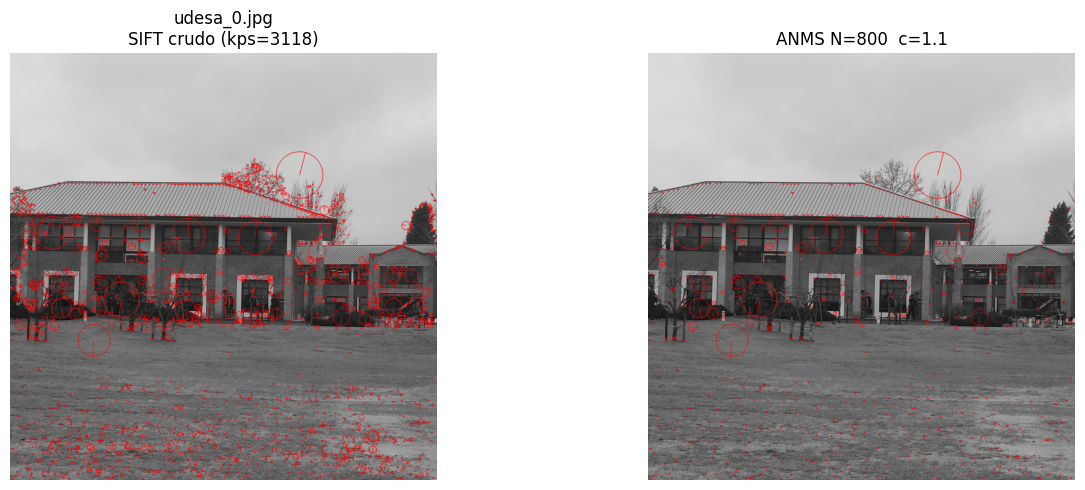

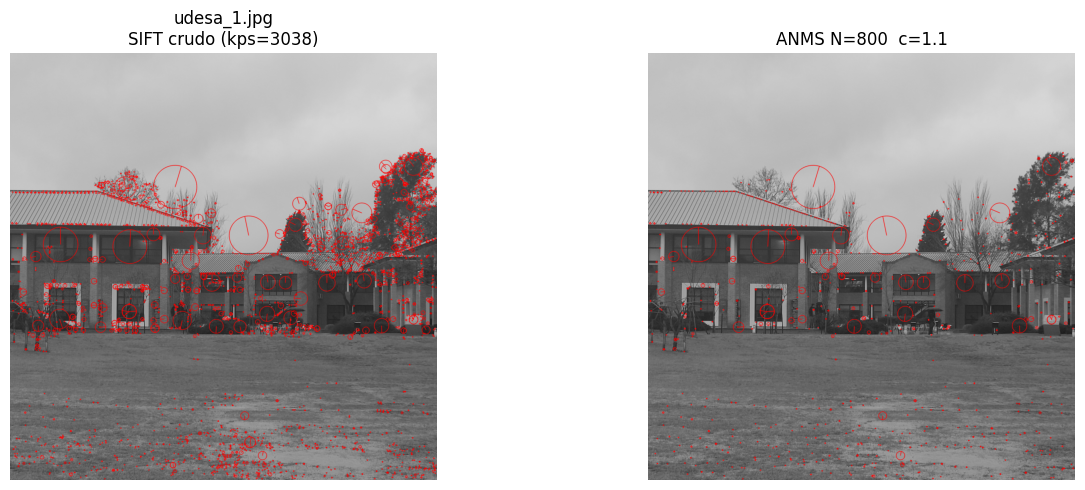

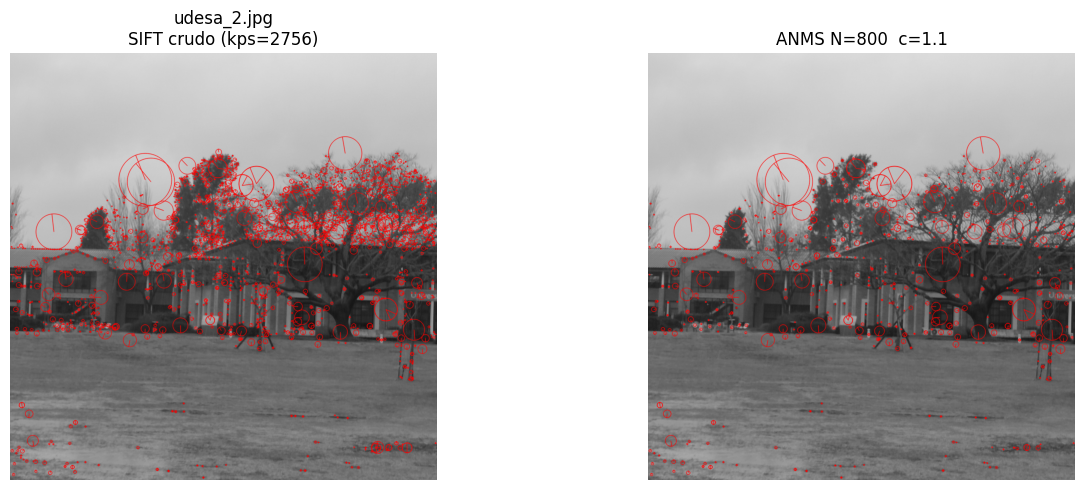

OK: ANMS listo. Pasamos a matching usando solo (kps_anms, desc_anms).


In [6]:
# === Etapa 2: ANMS (Adaptive Non-Maximal Suppression) ===
# Objetivo: quedarnos con N puntos fuertes y bien distribuidos (evita amontonamientos)

import numpy as np
import matplotlib.pyplot as plt
import cv2

def anms_select(keypoints, descriptors, N=800, c_robust=1.1):
    """
    ANMS clásico:
    - Para cada punto i, busco la distancia mínima a cualquier punto j "signif. más fuerte"
      (response_j >= c_robust * response_i).
    - Ese mínimo es el radio de supresión r_i.
    - Me quedo con los N de mayor r_i (fuertes + aislados).
    """
    n = len(keypoints)
    if n == 0:
        return [], None

    # coords (x, y) y fuerza (response) de cada kp
    pts = np.array([kp.pt for kp in keypoints], dtype=np.float32)     # (n, 2)
    resp = np.array([kp.response for kp in keypoints], dtype=np.float32)

    # ordeno por fuerza (desc) → “antes” de i son más fuertes
    order = np.argsort(-resp)
    radii = np.full(n, np.inf, dtype=np.float32)  # r_i

    # recorro de fuerte → débil y calculo radio contra puntos "suficientemente" más fuertes
    for rank, idx in enumerate(order):
        if rank == 0:
            continue  # el más fuerte queda con radio infinito
        stronger = order[:rank]
        mask = resp[stronger] >= c_robust * resp[idx]
        if not np.any(mask):
            continue
        cand = stronger[mask]
        d2 = np.sum((pts[cand] - pts[idx])**2, axis=1)
        radii[idx] = np.sqrt(d2.min())

    # selecciono los N con mayor radio
    N_eff = min(N, n)
    keep_idx = np.argsort(-radii)[:N_eff]

    kps_sel = [keypoints[i] for i in keep_idx]
    desc_sel = None if descriptors is None else descriptors[keep_idx]
    return kps_sel, desc_sel

# --- Aplicamos ANMS a cada imagen del set ---
N_TARGET = 800
C_ROBUST = 1.1

kps_anms_list, desc_anms_list = [], []
for i in range(3):
    kps = pano_data["kps"][i]
    desc = pano_data["desc"][i]
    kps_anms, desc_anms = anms_select(kps, desc, N=N_TARGET, c_robust=C_ROBUST)
    kps_anms_list.append(kps_anms)
    desc_anms_list.append(desc_anms)
    print(f"{pano_data['files'][i]}: antes={len(kps):4d}  después(ANMS)={len(kps_anms):4d}")

# guardo en el “paquete” para el siguiente paso
pano_data["kps_anms"] = kps_anms_list
pano_data["desc_anms"] = desc_anms_list
pano_data["anms_params"] = {"N": N_TARGET, "c_robust": C_ROBUST}

# --- Visualización: antes vs. después (por imagen, en gris) ---
for i in range(3):
    gray = pano_data["imgs_gray"][i]
    kps_all = pano_data["kps"][i]
    kps_sel = pano_data["kps_anms"][i]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    vis_all = cv2.drawKeypoints(gray, kps_all, None,
                                color=(255,0,0),
                                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    vis_sel = cv2.drawKeypoints(gray, kps_sel, None,
                                color=(255,0,0),
                                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    axes[0].imshow(vis_all, cmap="gray")
    axes[0].set_title(f"{pano_data['files'][i]}\nSIFT crudo (kps={len(kps_all)})")
    axes[0].axis("off")

    axes[1].imshow(vis_sel, cmap="gray")
    axes[1].set_title(f"ANMS N={len(kps_sel)}  c={C_ROBUST}")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

print("OK: ANMS listo. Pasamos a matching usando solo (kps_anms, desc_anms).")


### (3) Etapa 3 - Asociacion de caracteristicas (Matching) - 

udesa_1.jpg ↔ udesa_0.jpg: matches ratio= 201  


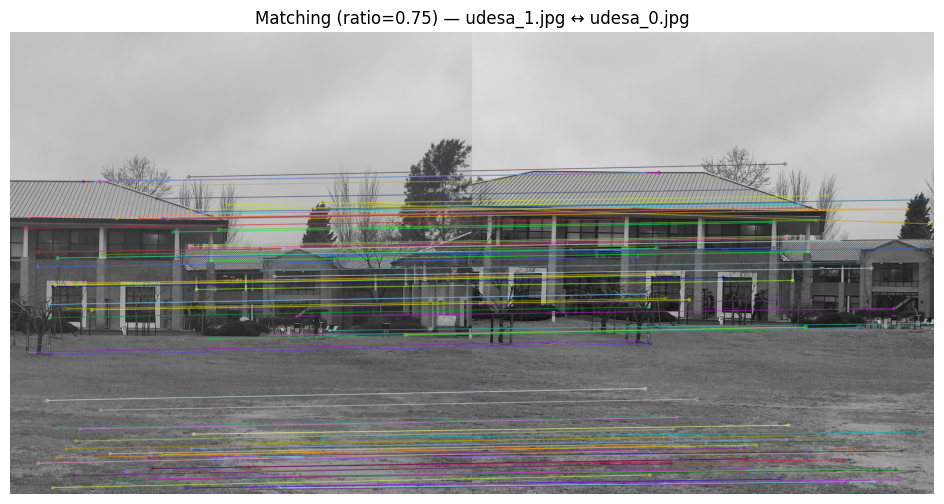

udesa_1.jpg ↔ udesa_2.jpg: matches ratio=  52  


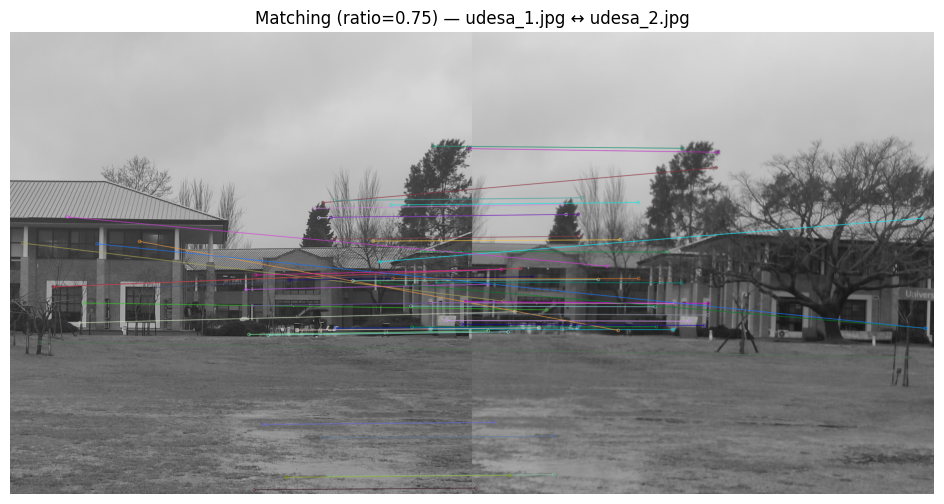

OK: Matching listo. Usá pano_data['matches'][<par>]['ptsA'/'ptsB'] para DLT/RANSAC.


In [7]:
# === Etapa 3.3: Asociación de características (Matching) ===
# Idea: usar descriptores SIFT (filtrados por ANMS) para emparejar puntos entre imágenes.
# Herramientas: BFMatcher + knnMatch(k=2), Lowe ratio test, opcional cross-check.

import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import sample

# --- helpers ---

def _ensure_anms(pano_data):
    """Si no corriste ANMS aún, usa SIFT crudo. Caso normal: usa kps/desc de ANMS."""
    if "kps_anms" in pano_data and "desc_anms" in pano_data:
        return pano_data["kps_anms"], pano_data["desc_anms"]
    return pano_data["kps"], pano_data["desc"]

def lowe_ratio_filter(knn_matches, ratio=0.75):
    """Aplico ratio test: me quedo con m si dist(m) < ratio * dist(n)."""
    good = []
    for m, n in knn_matches:
        if m.distance < ratio * n.distance:
            good.append(m)
    return good

def cross_check_filter(matches_ab, matches_ba):
    """
    Cross-check simétrico:
    - matches_ab: mejores matches A->B (lista de DMatch con queryIdx en A, trainIdx en B)
    - matches_ba: mejores matches B->A
    Me quedo solo con parejas que sean recíprocas.
    """
    map_ab = {(m.queryIdx, m.trainIdx) for m in matches_ab}
    map_ba = {(m.trainIdx, m.queryIdx) for m in matches_ba}
    inter = map_ab & map_ba  # pares recíprocos
    return [cv2.DMatch(_queryIdx=i, _trainIdx=j, _imgIdx=0, _distance=0) for (i, j) in inter]

def extract_matched_points(kpsA, kpsB, matches):
    """De DMatch -> arrays Nx2 de coordenadas (x,y) en cada imagen."""
    ptsA = np.float32([kpsA[m.queryIdx].pt for m in matches])
    ptsB = np.float32([kpsB[m.trainIdx].pt for m in matches])
    return ptsA, ptsB

def draw_matches_gray(grayA, grayB, kpsA, kpsB, matches, max_draw=80, title=""):
    """
    Visualizo matches sobre fondo gris (estilo clase).
    - Submuestreo para no saturar la figura (max_draw).
    """
    if len(matches) > max_draw:
        matches = [matches[i] for i in sorted(sample(range(len(matches)), max_draw))]
    # drawMatches espera BGR de 3 canales
    A_bgr = cv2.cvtColor(grayA, cv2.COLOR_GRAY2BGR)
    B_bgr = cv2.cvtColor(grayB, cv2.COLOR_GRAY2BGR)
    vis = cv2.drawMatches(A_bgr, kpsA, B_bgr, kpsB, matches, None,
                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(14, 6))
    # Mostrar en RGB para matplotlib
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

# --- matching principal (ancla vs vecinos) ---

# Tomo los keypoints/desc filtrados
kps_list, desc_list = _ensure_anms(pano_data)

anchor = pano_data["anchor_idx"]
pairs = []
if anchor - 1 >= 0: pairs.append((anchor, anchor - 1))   # ancla ↔ izquierda
if anchor + 1 < len(kps_list): pairs.append((anchor, anchor + 1))  # ancla ↔ derecha

# Parámetros típicos
RATIO = 0.75        # Lowe ratio
DO_CROSSCHECK = False  # podés probar True para combinar políticas

matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)  # SIFT -> NORM_L2

match_results = {}  # guardo todo para homografía
for iA, iB in pairs:
    descA, descB = desc_list[iA], desc_list[iB]
    kpsA,  kpsB  = kps_list[iA], kps_list[iB]

    # knn (2 vecinos) en ambos sentidos
    knnAB = matcher.knnMatch(descA, descB, k=2)
    knnBA = matcher.knnMatch(descB, descA, k=2)

    # Lowe ratio
    goodAB = lowe_ratio_filter(knnAB, ratio=RATIO)
    goodBA = lowe_ratio_filter(knnBA, ratio=RATIO)

    # Opcional: cross-check simétrico sobre los good
    if DO_CROSSCHECK:
        good = cross_check_filter(goodAB, goodBA)
    else:
        good = goodAB

    # Extraigo puntos emparejados
    ptsA, ptsB = extract_matched_points(kpsA, kpsB, good)

    # Guardo para próximos pasos
    key = f"{pano_data['files'][iA]} ↔ {pano_data['files'][iB]}"
    match_results[key] = {
        "iA": iA, "iB": iB,
        "matches": good,
        "ptsA": ptsA, "ptsB": ptsB,
        "kpsA": kpsA, "kpsB": kpsB
    }

    # Logs rápidos
    print(f"{key}: matches ratio={len(goodAB):4d}  "
          + (f"(ratio+cross={len(good):4d})" if DO_CROSSCHECK else ""))

    # Visualización (gris, con submuestreo para claridad)
    draw_matches_gray(
        pano_data["imgs_gray"][iA],
        pano_data["imgs_gray"][iB],
        kpsA, kpsB, good,
        max_draw=100,
        title=f"Matching (ratio={RATIO}" + (", cross-check" if DO_CROSSCHECK else "") + f") — {key}"
    )

# Empaqueto resultados para homografía (paso 4/5)
pano_data["matches"] = match_results
pano_data["matching_params"] = {"ratio": RATIO, "cross_check": DO_CROSSCHECK}

print("OK: Matching listo. Usá pano_data['matches'][<par>]['ptsA'/'ptsB'] para DLT/RANSAC.")


=== Política A: SOLO Lowe ratio ===
udesa_1.jpg ↔ udesa_0.jpg: matches (ratio=0.75) = 201


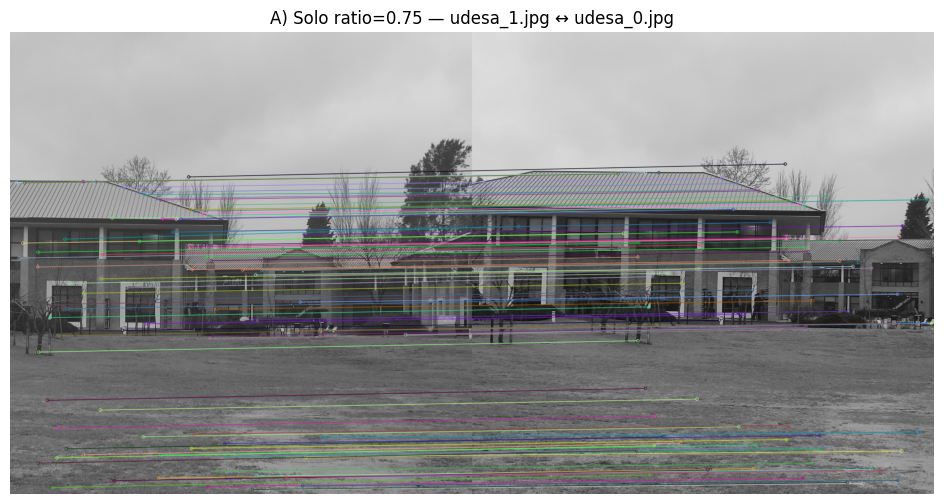

udesa_1.jpg ↔ udesa_2.jpg: matches (ratio=0.75) = 52


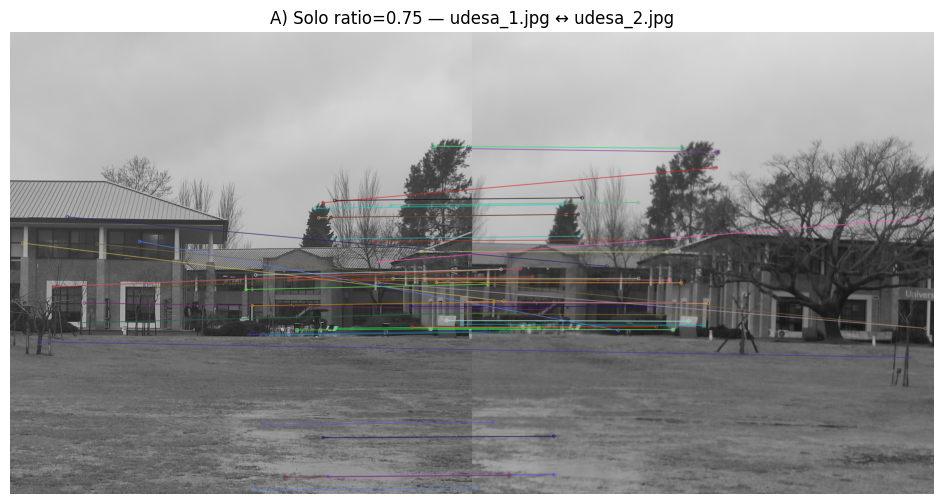


=== Política B: Lowe ratio + Cross-check ===
udesa_1.jpg ↔ udesa_0.jpg: matches (ratio+cross) = 155  |  solo ratio tenía 201


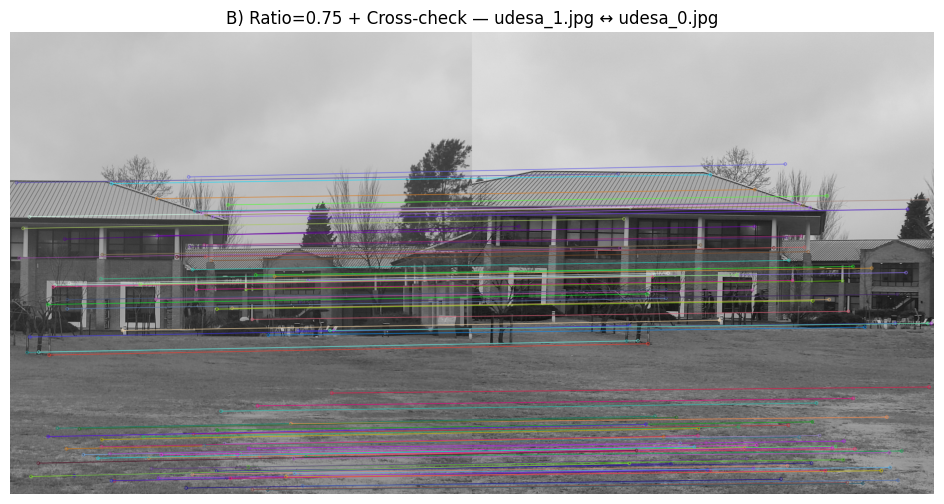

udesa_1.jpg ↔ udesa_2.jpg: matches (ratio+cross) = 36  |  solo ratio tenía 52


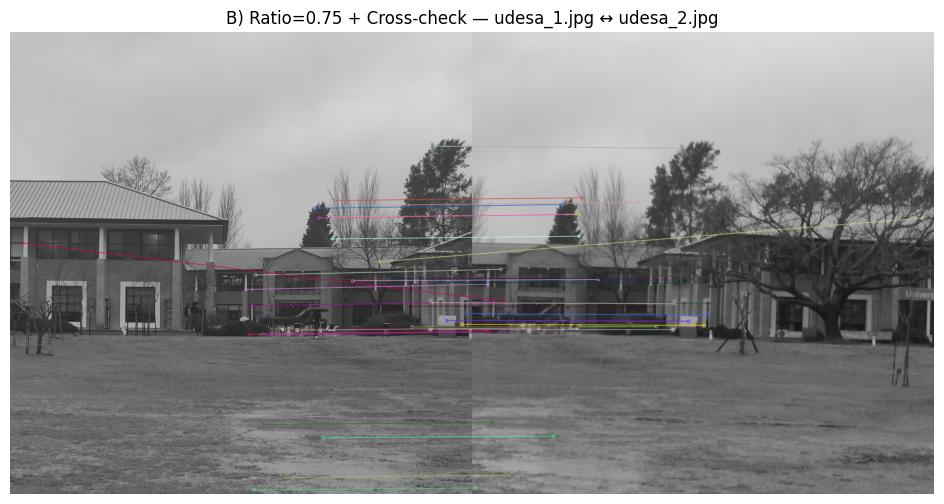


Listo: tenés ambos sets en pano_data['matches_ratio'] y ['matches_ratio_xcheck'] para DLT/RANSAC.


In [8]:
# === Etapa 3.3 (mini): comparación de políticas de matching ===
import cv2, numpy as np, matplotlib.pyplot as plt
from random import sample

def lowe_ratio_filter(knn_matches, ratio=0.75):
    good = []
    for m, n in knn_matches:
        if m.distance < ratio * n.distance:
            good.append(m)
    return good

def cross_check_filter(matches_ab, matches_ba):
    AB = {(m.queryIdx, m.trainIdx) for m in matches_ab}
    BA = {(m.trainIdx, m.queryIdx) for m in matches_ba}
    inter = AB & BA
    # reconstruyo DMatch para dibujar/llevar a pts
    return [cv2.DMatch(_queryIdx=i, _trainIdx=j, _imgIdx=0, _distance=0) for (i, j) in inter]

def extract_pts(kpsA, kpsB, matches):
    ptsA = np.float32([kpsA[m.queryIdx].pt for m in matches])
    ptsB = np.float32([kpsB[m.trainIdx].pt for m in matches])
    return ptsA, ptsB

def draw_matches_gray(grayA, grayB, kpsA, kpsB, matches, title, max_draw=80):
    if len(matches) > max_draw:
        idxs = sorted(sample(range(len(matches)), max_draw))
        matches = [matches[i] for i in idxs]
    A = cv2.cvtColor(grayA, cv2.COLOR_GRAY2BGR)
    B = cv2.cvtColor(grayB, cv2.COLOR_GRAY2BGR)
    vis = cv2.drawMatches(A, kpsA, B, kpsB, matches, None,
                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(14,6))
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.title(title); plt.axis("off"); plt.show()

# --- Datos (usamos ANMS si está; si no, SIFT crudo) ---
kps_list = pano_data.get("kps_anms", pano_data["kps"])
desc_list = pano_data.get("desc_anms", pano_data["desc"])
anchor = pano_data["anchor_idx"]

pairs = []
if anchor - 1 >= 0: pairs.append((anchor, anchor-1))
if anchor + 1 < len(kps_list): pairs.append((anchor, anchor+1))

# --- Parámetros ---
RATIO = 0.75
matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)  # SIFT -> L2

# --- A) SOLO RATIO ---
matches_ratio = {}
print("=== Política A: SOLO Lowe ratio ===")
for iA, iB in pairs:
    kpsA, kpsB = kps_list[iA], kps_list[iB]
    descA, descB = desc_list[iA], desc_list[iB]

    knnAB = matcher.knnMatch(descA, descB, k=2)
    goodAB = lowe_ratio_filter(knnAB, ratio=RATIO)

    ptsA, ptsB = extract_pts(kpsA, kpsB, goodAB)
    key = f"{pano_data['files'][iA]} ↔ {pano_data['files'][iB]}"
    matches_ratio[key] = {"matches": goodAB, "ptsA": ptsA, "ptsB": ptsB, "iA": iA, "iB": iB}

    print(f"{key}: matches (ratio={RATIO}) = {len(goodAB)}")
    draw_matches_gray(pano_data["imgs_gray"][iA], pano_data["imgs_gray"][iB],
                      kpsA, kpsB, goodAB, title=f"A) Solo ratio={RATIO} — {key}", max_draw=100)

pano_data["matches_ratio"] = matches_ratio

# --- B) RATIO + CROSS-CHECK ---
matches_ratio_xc = {}
print("\n=== Política B: Lowe ratio + Cross-check ===")
for iA, iB in pairs:
    kpsA, kpsB = kps_list[iA], kps_list[iB]
    descA, descB = desc_list[iA], desc_list[iB]

    knnAB = matcher.knnMatch(descA, descB, k=2)
    knnBA = matcher.knnMatch(descB, descA, k=2)

    goodAB = lowe_ratio_filter(knnAB, ratio=RATIO)
    goodBA = lowe_ratio_filter(knnBA, ratio=RATIO)
    both = cross_check_filter(goodAB, goodBA)

    ptsA, ptsB = extract_pts(kpsA, kpsB, both)
    key = f"{pano_data['files'][iA]} ↔ {pano_data['files'][iB]}"
    matches_ratio_xc[key] = {"matches": both, "ptsA": ptsA, "ptsB": ptsB, "iA": iA, "iB": iB}

    print(f"{key}: matches (ratio+cross) = {len(both)}  |  solo ratio tenía {len(goodAB)}")
    draw_matches_gray(pano_data["imgs_gray"][iA], pano_data["imgs_gray"][iB],
                      kpsA, kpsB, both, title=f"B) Ratio={RATIO} + Cross-check — {key}", max_draw=100)

pano_data["matches_ratio_xcheck"] = matches_ratio_xc

print("\nListo: tenés ambos sets en pano_data['matches_ratio'] y ['matches_ratio_xcheck'] para DLT/RANSAC.")


### (4) Etapa 4 - Estimacion de la Homografia 'manualmente' - 